<img src="https://previews.123rf.com/images/trimulyani/trimulyani2002/trimulyani200201852/141090583-call-phone-icon-telephone-icon-vector-design-symbol.jpg" style="float: left; margin: 20px; height: 85px">

# 3 - Neural Network Model

<span style="font-size: 16px;">In this notebook, we will develop a convolutional neural network (CNN) model for the speech emotion recognition. Data has been transformed into mel spectrograms and to tensorflow data format. These spectrograms, which visually represent the strength of different frequencies over time, resemble image data, making a CNN an appropriate choice for this task. To facilitate the training process, the data was converted into a TensorFlow-compatible format.

### Importing libraries

In [14]:
import os
import tempfile
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import models
import IPython
from IPython import display
import librosa
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Setting data to TensorFlow data format

In [15]:
# listing files to later read them and their label
list_ds = tf.data.Dataset.list_files('../data/*/*.wav')
# checking the type of list_ds variable
print(list_ds)
# inspect the type of each element component
print(list_ds.element_spec)
# Use value_type to see the type of value represented by the element spec
print(list_ds.element_spec.value_type)

<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
TensorSpec(shape=(), dtype=tf.string, name=None)
<class 'tensorflow.python.framework.ops.Tensor'>


In [16]:
# length of the dataset
len(list_ds)
len_ds = len(list_ds)

In [17]:
emotion_dict = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fearful', 7:'disgust', 8:'surprised'}

<span style="font-size: 16px;"> Applying preprocess steps:

In [18]:
# creating a function that will receive the filename in the list_ds
# and return the spectrogram of the file and its label
def load_audio(filename):
    #getting the label from the filename
    parts = tf.strings.split(filename, sep='-')
    label = int(parts[-5])-1
    # loading the file using librosa
    filename = filename.numpy().decode('utf-8')
    audio, sr = librosa.load(filename, sr=None)
    # setting a threshold of 20 below reference to be considered as silence
    audio, _ = librosa.effects.trim(audio, top_db=20)
    # resampling audio to 22500 values per second
    audio = librosa.resample(audio, orig_sr=sr, target_sr=22500)
    # setting the same length - 2 seconds of audio
    target_size = 45000
    if len(audio) > target_size:
        audio = audio[:target_size]
    elif len(audio) < target_size:
        audio = librosa.util.pad_center(audio, size=target_size, axis=0) # 88200 is 4s of audio, at sample rate 22050
    # getting the melspectrogram of the audio
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels = 128, )
    # converting the amplitude to db - approximates to how humans perceive sound
    spectrogram = librosa.amplitude_to_db(S, ref = np.max)
    #expanding dimension to match the shape expected in the convolutional NN    
    spectrogram = np.expand_dims(spectrogram, axis=2)
    # convert the spectrogram to a TensorFlow tensor to use tensorflow pipeline
    spectrogram = tf.convert_to_tensor(spectrogram, dtype=tf.float32)
    return spectrogram, label

In [19]:
# applying load_audio in an individual file
# spec shape will be used in modelling
file_path = next(iter(list_ds))
spec, label = load_audio(file_path)
print(spec.shape)
print(label)

(128, 88, 1)
1


In [20]:
# applying load_audio to the whole list_ds dataset
# this map method using python functions was extracted from tensorflow.data API tutorials
audios_ds = list_ds.map(lambda filename:\
                tf.py_function(func=load_audio, inp=[filename], Tout=[tf.float32, tf.int32]))
audios_ds = audios_ds.map(lambda spectrogram, label: (tf.reshape(spectrogram, [128,88,1]), tf.reshape(label,[])))
# now audios_ds contains the spectrograms and their respective labels
audios_ds.element_spec

(TensorSpec(shape=(128, 88, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [21]:
# shuffle the dataset that is currently ordered by class
audios_ds = audios_ds.shuffle(buffer_size=len_ds)

In [22]:
# taking 80% of the dataset to training set and the remaining 20% to the validation set
train = audios_ds.take(int(0.8*len_ds)).cache().batch(32).prefetch(tf.data.AUTOTUNE)
test = audios_ds.skip(int(0.8*len_ds)).take(int(0.2*len_ds)).cache().batch(32).prefetch(tf.data.AUTOTUNE)

## Creating model

<span style="font-size: 16px;">  Two versions of the model were created: one without a bias initializer and one with a bias initializer.

In [23]:
input_shape = spec.shape
print('Input shape:', input_shape)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train.map(map_func=lambda spec, label: spec))

def make_model(output_bias=None):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        norm_layer,
        layers.Conv2D(64, 5, activation='relu'),
        layers.Conv2D(128, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(8, activation = 'softmax', bias_initializer=output_bias),
    ])

    model.compile(
        loss='sparse_categorical_crossentropy', 
        optimizer='rmsprop',
        metrics=['acc']
    )
    return model


model = make_model()
model.summary()

Input shape: (128, 88, 1)


2024-07-30 11:13:35.251548: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 556 of 1439
2024-07-30 11:13:45.257241: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 1108 of 1439
2024-07-30 11:13:51.025556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normaliza  (None, 128, 88, 1)        3         
 tion)                                                           
                                                                 
 conv2d_8 (Conv2D)           (None, 124, 84, 64)       1664      
                                                                 
 conv2d_9 (Conv2D)           (None, 122, 82, 128)      73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 61, 41, 128)       0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 61, 41, 128)       0         
                                                                 
 flatten_4 (Flatten)         (None, 320128)           

<span style="font-size: 16px;"> Let's compare initial loss of the model created with bias and without:

In [24]:
no_bias = make_model()
no_bias_results = no_bias.evaluate(train, verbose=0)
print(f'No bias initial loss: {no_bias_results[0]}')

#saving weights to compare the models' fitting equally
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

bias = np.log([1/8])
bias = tf.keras.initializers.Constant(bias)
with_bias = make_model(output_bias=bias)
bias_results = with_bias.evaluate(train, verbose=0)
print(f'With bias initial loss: {bias_results[0]}')

No bias initial loss: 2.1384260654449463
With bias initial loss: 2.0869545936584473


In [25]:
# #saving weights to compare the models' fitting equally
# initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
# model.save_weights(initial_weights)

In [27]:
no_bias = make_model()
no_bias.load_weights(initial_weights)
no_bias.layers[-1].bias.assign(np.zeros(8))

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3),
    tf.keras.callbacks.ModelCheckpoint(filepath='../models/no_bias.h5',save_best_only=True)]

no_bias_history = no_bias.fit(
    train,
    validation_data=test,
    epochs=20,
    callbacks = callbacks)

Epoch 1/20
36/36 [==============================] - 19s 536ms/step - loss: 6.4038 - acc: 0.2311 - val_loss: 1.5845 - val_acc: 0.5993
Epoch 2/20


/Users/gabrielafichtner/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 21s 587ms/step - loss: 1.5569 - acc: 0.4492 - val_loss: 0.9480 - val_acc: 0.7805
Epoch 3/20
36/36 [==============================] - 21s 580ms/step - loss: 1.0420 - acc: 0.6342 - val_loss: 0.4646 - val_acc: 0.8537
Epoch 4/20
36/36 [==============================] - 20s 567ms/step - loss: 0.5337 - acc: 0.8193 - val_loss: 0.3025 - val_acc: 0.9199
Epoch 5/20
36/36 [==============================] - 20s 551ms/step - loss: 0.3013 - acc: 0.9001 - val_loss: 0.2055 - val_acc: 0.9338
Epoch 6/20
36/36 [==============================] - 19s 539ms/step - loss: 0.1626 - acc: 0.9479 - val_loss: 0.2409 - val_acc: 0.9233
Epoch 7/20
36/36 [==============================] - 19s 538ms/step - loss: 0.1259 - acc: 0.9574 - val_loss: 0.2212 - val_acc: 0.9164
Epoch 8/20
36/36 [==============================] - 19s 533ms/step - loss: 0.0880 - acc: 0.9687 - val_loss: 0.2291 - val_acc: 0.9373


In [28]:
bias = np.log([1/8])
bias = tf.keras.initializers.Constant(bias)
with_bias = make_model(output_bias=bias)
with_bias.load_weights(initial_weights)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3),
    tf.keras.callbacks.ModelCheckpoint(filepath='../models/with_bias.h5',save_best_only=True)]

with_bias_history = with_bias.fit(
    train,
    validation_data=test,
    epochs=20,
    callbacks = callbacks)

Epoch 1/20
36/36 [==============================] - 19s 535ms/step - loss: 6.7778 - acc: 0.2511 - val_loss: 1.5887 - val_acc: 0.4983
Epoch 2/20
36/36 [==============================] - 19s 532ms/step - loss: 1.5760 - acc: 0.4240 - val_loss: 1.0015 - val_acc: 0.7631
Epoch 3/20
36/36 [==============================] - 19s 528ms/step - loss: 1.0942 - acc: 0.6195 - val_loss: 0.5688 - val_acc: 0.8467
Epoch 4/20
36/36 [==============================] - 19s 531ms/step - loss: 0.6192 - acc: 0.8063 - val_loss: 0.2838 - val_acc: 0.9233
Epoch 5/20
36/36 [==============================] - 19s 536ms/step - loss: 0.3393 - acc: 0.8827 - val_loss: 0.2347 - val_acc: 0.9199
Epoch 6/20
36/36 [==============================] - 19s 531ms/step - loss: 0.1993 - acc: 0.9357 - val_loss: 0.2165 - val_acc: 0.9233
Epoch 7/20
36/36 [==============================] - 19s 528ms/step - loss: 0.1599 - acc: 0.9418 - val_loss: 0.2346 - val_acc: 0.9233
Epoch 8/20
36/36 [==============================] - 71s 2s/step - los

<span style="font-size: 16px;"> Let's now compare the fitting of both:

In [29]:
colors = ['orange', 'blue']

def plot_loss(history, label, n):
    # Use a log scale on y-axis to show the wide range of values.
    plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
    plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

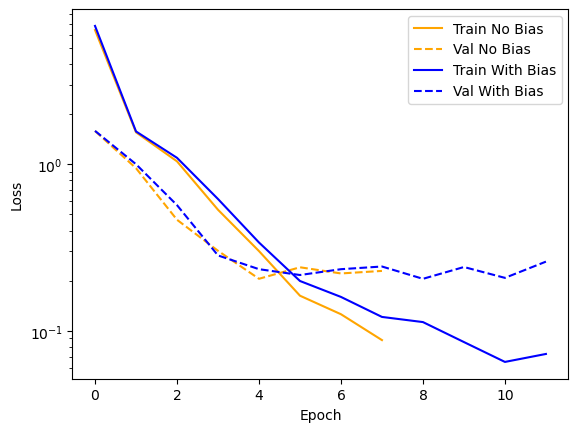

In [30]:
plot_loss(no_bias_history, 'No Bias', 0)
plot_loss(with_bias_history, 'With Bias', 1)

<span style="font-size: 16px;"> The models with and without bias initialization showed similar loss values in the first epoch, and both achieved over 90% accuracy on the training and validation sets. The model without bias initialization performed slightly better in terms of validation loss, achieving approximately 92.7% validation accuracy, compared to 92.3% for the model with bias initialization. Based on these results, the model without bias initialization will be trained with the whole dataset and will be used for further inference.

# Confusion Matrix

9/9 [==============================] - 1s 127ms/step


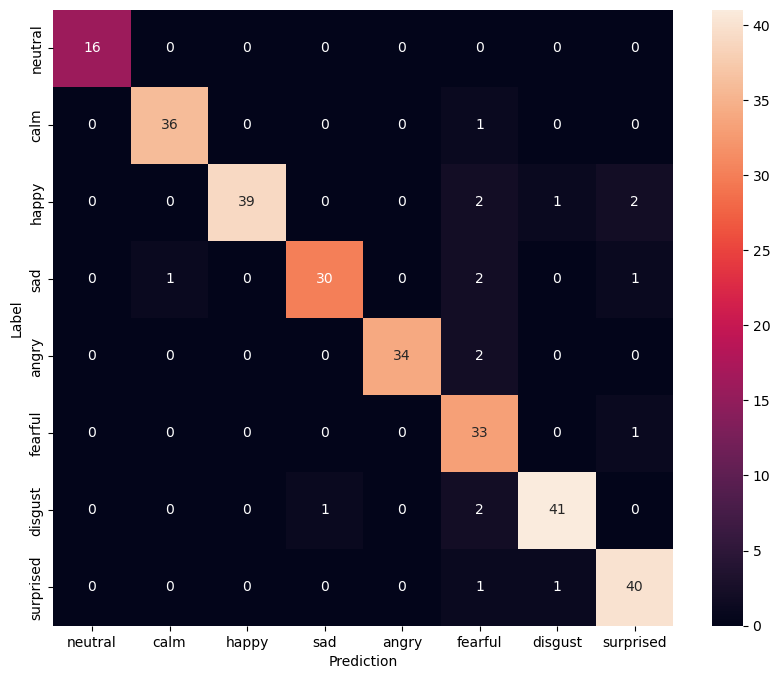

In [40]:
y_pred = no_bias.predict(test)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test.map(lambda s,lab: lab)), axis=0)


confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=emotion_dict.values(),
            yticklabels=emotion_dict.values(),
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

<span style="font-size: 16px;">The model accurately predicted all neutral samples from test set. From least to the more confused predictions were: 1 of 37 calm samples confused with fearful, 1/34 fearful with surprised, 2/42 surprised with fearful and disgust, 2/36 angry with fearful, 3/44 disgust with fearful and sad, 5/44 of happy and 4/34 sad confused ones. <Br>
Some confusions were similar to what I perceived the original audios in notebook 1, such as sad with calm and happy with fearful.
<br>
The results do not seem to present a pattern of confusing two emotions with each other equally, except fearful and surprised. Happy is the only positive emotion and was surprisingly confused with negative emotions (fearful and disgust).
    <br> Let's train the model with the whole dataset and see how it performs on unseen data.

# Training Model with whole dataset

In [31]:
audios_ds = audios_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [32]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign(np.zeros(8))


model_history = model.fit(
    audios_ds,
    epochs=9)

Epoch 1/9


2024-07-30 11:26:24.505783: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 751 of 1439
2024-07-30 11:26:33.584358: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] Shuffle buffer filled.


45/45 [==============================] - 42s 508ms/step - loss: 4.1027 - acc: 0.2377
Epoch 2/9
45/45 [==============================] - 24s 524ms/step - loss: 1.4980 - acc: 0.4802
Epoch 3/9
45/45 [==============================] - 24s 526ms/step - loss: 0.9240 - acc: 0.6880
Epoch 4/9
45/45 [==============================] - 23s 510ms/step - loss: 0.5296 - acc: 0.8158
Epoch 5/9
45/45 [==============================] - 23s 515ms/step - loss: 0.2709 - acc: 0.8999
Epoch 6/9
45/45 [==============================] - 23s 501ms/step - loss: 0.1987 - acc: 0.9361
Epoch 7/9
45/45 [==============================] - 22s 498ms/step - loss: 0.1167 - acc: 0.9590
Epoch 8/9
45/45 [==============================] - 22s 496ms/step - loss: 0.1390 - acc: 0.9562
Epoch 9/9
45/45 [==============================] - 22s 496ms/step - loss: 0.0664 - acc: 0.9812


# Running Inference on an audio file

In [35]:
def inference_audio(filename):
    audio, sr = librosa.load(filename)
    # setting a threshold of 20 below reference to be considered as silence
    audio, _ = librosa.effects.trim(audio, top_db=20)
    # resampling audio to 22500 values per second
    audio = librosa.resample(audio, orig_sr=sr, target_sr=22500)
    # setting the same length
    target_size = 45000
    if len(audio) > target_size:
        audio = audio[:target_size]
    elif len(audio) < target_size:
        audio = librosa.util.pad_center(audio, size=target_size, axis=0) # 88200 is 4s of audio, at sample rate 22050
    # getting the melspectrogram of the audio
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    # converting the amplitude to db - approximates to how humans perceive sound
    spectrogram = librosa.amplitude_to_db(S, ref=np.max)
    # expanding dimension to match the shape expected in the convolutional NN    
    spectrogram = np.expand_dims(spectrogram, axis=2)
    # convert the spectrogram to a TensorFlow tensor to use tensorflow pipeline
    spectrogram = tf.convert_to_tensor(spectrogram, dtype=tf.float32)
    # reshape to (128, 173, 1)
    spectrogram = tf.reshape(spectrogram, [128, 88, 1])
    # add batch dimension to the input tensor
    spectrogram = tf.expand_dims(spectrogram, axis=0)
    return spectrogram

In [36]:
!ls '../audios'

angry.m4a


In [37]:
angry = '../audios/angry.m4a'

In [38]:
audio, sr = librosa.load(angry)
print('Play audio:')
IPython.display.Audio(audio, rate=sr)

Play audio:


/var/folders/wn/9gkbqd6944j2c2zg298yhc3c0000gn/T/ipykernel_21438/3921734382.py:1: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(angry)


Prediction audio:
1/1 [==============================] - 0s 39ms/step


/var/folders/wn/9gkbqd6944j2c2zg298yhc3c0000gn/T/ipykernel_21438/1588141151.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(filename)


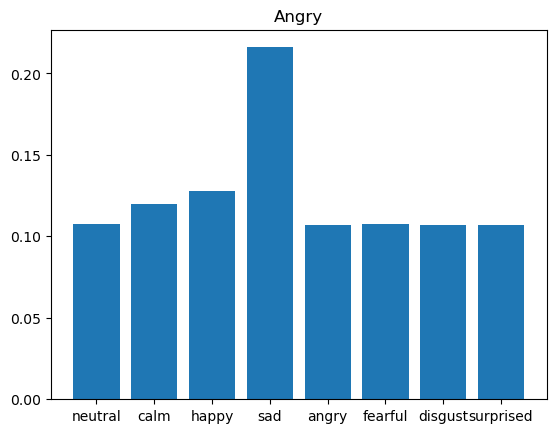

In [39]:
x = inference_audio(angry)
print('Prediction audio:')
# extract predictions
prediction = model.predict(x)
x_labels = emotion_dict.values()
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Angry')
plt.show()

<span style="font-size: 16px;">The model struggled to accurately predict unseen data, when the voice and statements differed from the training set. Notably, an audio sample expressing anger was misclassified as sadness. This issue is significant, as the confusion matrix showed that these two emotions were not confused in the validation set, indicating that the model lacks robustness when generalizing to new, diverse inputs. This suggests that the model may require further training with a more varied dataset or additional tuning to improve its ability to handle unseen data effectively.

## Next Steps

<span style="font-size: 16px;"> The model successfully learned the complexities of the eight emotions with the train and validation sets, achieving a validation accuracy of over 90%. However, it performed poorly on unseen data, indicating a potential issue with generalization. To enhance the model's robustness for real-world applications, it would be ideal to train it on a more datasets to include a wider range of statements and voices. Additionally, implementing data augmentation techniques could help the model better generalize to variations in speech and context.

References:
- TensorFlow Tutorials: [classification on imbalanced dataset](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#optional_set_the_correct_initial_bias) and [simple audio recognition](https://www.tensorflow.org/tutorials/audio/simple_audio)
- Nicholas Renotte's Audio Classification tutorial on youtube: https://www.youtube.com/watch?v=ZLIPkmmDJAc